# Простой генератор данных для домашнего задания
Можете побаловаться в генерации и настройках

In [12]:
import pandas as pd
import numpy as np

# Настройки для симуляции данных
np.random.seed(40)  # Для воспроизводимости результатов
num_days = 20
min_users_per_day = 100
max_users_per_day = 500
date_range = pd.date_range(start='2024-02-01', periods=num_days, freq='D')

# Генерация количества пользователей в день
users_per_day = np.random.randint(min_users_per_day, max_users_per_day + 1, size=num_days)

# Инициализация DataFrame
data = pd.DataFrame({
    "date": np.repeat(date_range, users_per_day),
    "group": np.nan,  # Будет заполнено позже
    "conversion": np.nan,  # Будет заполнено позже
    "LTV": np.nan  # Будет заполнено позже
})

# Заполнение групп аб теста
data["group"] = np.random.choice([0, 1], size=len(data))

# Заполнение конверсий с небольшим преимуществом для группы 1
conversion_rates = {0: 0.2, 1: 0.22}  # Небольшое преимущество для группы 1
data["conversion"] = data["group"].map(lambda g: np.random.choice([0, 1], p=[1-conversion_rates[g], conversion_rates[g]]))

# Заполнение LTV с небольшим преимуществом для группы 1
ltv_means = {0: 100, 1: 110}  # Средние значения LTV для каждой группы
ltv_std_dev = 20  # Стандартное отклонение LTV
data["LTV"] = data["group"].map(lambda g: np.maximum(0, np.random.normal(ltv_means[g], ltv_std_dev)))

data.head()

,date,group,conversion,LTV
0,2024-02-01,0,0,79.791774
1,2024-02-01,0,0,100.089491
2,2024-02-01,1,1,104.696552
3,2024-02-01,0,0,82.928757
4,2024-02-01,0,0,130.937933


# Анализ и тесты
Здесь ваша практика

In [65]:
# импортируем библиотеки для проведения анализа результата эксперимента

from scipy.stats import (
    mannwhitneyu, # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu
    chi2_contingency, # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency
    ttest_ind # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind
    )

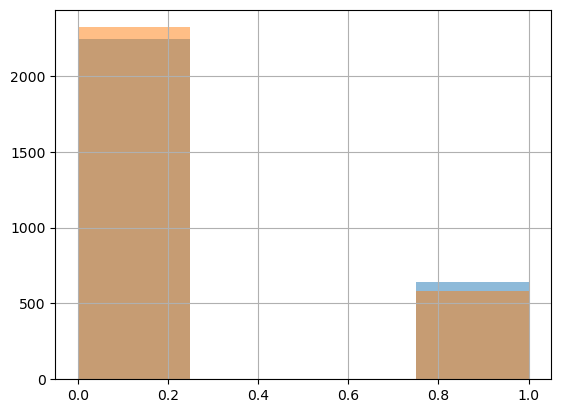

In [11]:
# посмотрев на распределение ргуппы конверсий в регистрацию,
# можем сделать вывод, что у нас дискретные величины, к которым можно применить метод хи квадрата

for group in data.group.unique():
    data[data.group == group].conversion.hist(bins=4, alpha=.5)

### Здесь необходимо рассчитать результатаы теста:

In [23]:
# подготовим данные в виде сводной таблицы
conversion_table = data.pivot_table(index='group', columns='conversion', aggfunc='size', fill_value=0)
display(conversion_table)


from scipy.stats import chi2_contingency

# Данные о группах и конверсиях
data_2 = [[2237, 539],  # group 1: conversion 0, conversion 1
        [2305, 618]]  # group 2: conversion 0, conversion 1

# хи-квадрат
chi2, p, dof, expected = chi2_contingency(data_2)

chi2, p, dof, expected

# p-value = 0.112 > 0.05, это позволяет нам принять нулевую гипотизу
# делаем вывод об отсутствие значимой разницý между вýборками.

conversion,0,1
group,,
0,2237,539
1,2305,618


(2.516600136235263,
 0.1126532322826482,
 1,
 array([[2212.42182839,  563.57817161],
        [2329.57817161,  593.42182839]]))

,date,group,visit_to_reg
,,,
0,2024-02-01,0,0.169231
1,2024-02-02,0,0.156863
2,2024-02-03,0,0.207547
3,2024-02-04,0,0.211679
4,2024-02-05,0,0.222222


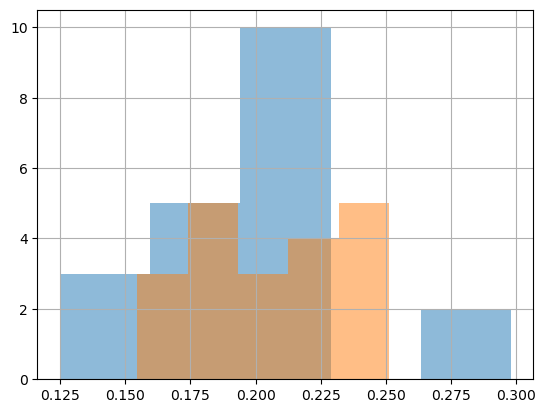

In [13]:
# подготовим данные для U и T тестов, преобразовав дискретные значения колонки conversion в неприрывные

groupped_data = data.groupby(['group', 'date']).agg({ # группируем данные по дате и группе в тесте
    'conversion': ['count', 'sum'], # подсчитываем число наблюдений и исло конвесий в день
}).reset_index() # удаляем индекс, что бы индексы group и date после группировки стали обратно колонками

# теперь расчитываем конверсию из визита в регистрацию, разделив число регистраций в день на число визитов в день
groupped_data['visit_to_reg'] = groupped_data['conversion']['sum'] / groupped_data['conversion']['count']

# оставляем только нужные нам колонки
groupped_data = groupped_data[['date', 'group', 'visit_to_reg']]
display(groupped_data.head())

for group in groupped_data.group.unique():
    groupped_data[groupped_data.group == group].visit_to_reg.hist(bins=5, alpha=.5)

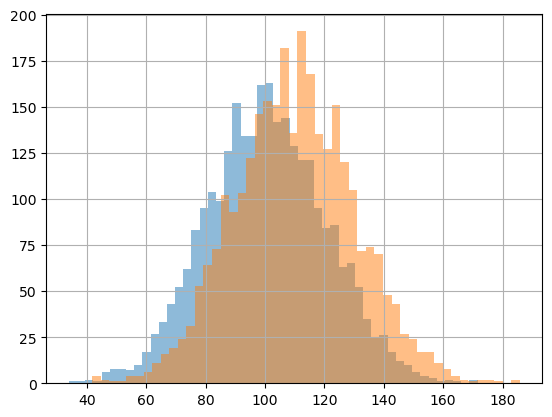

In [24]:
# Смотрим, как распределяются данные LTV

for group in data.group.unique():
    data[data.group == group].LTV.hist(bins=50, alpha=.5)

In [16]:
# проверяем оба наших набора данных методом Шапиро-Уилка на нормальность распределения,
# и как следствие возможность применения t-теста

from scipy.stats import shapiro

shapiro_visit_to_reg = {group: shapiro(groupped_data[groupped_data.group == group].visit_to_reg.values) for group in groupped_data.group.unique()}
shapiro_ltv = {group: shapiro(data[data.group == group].LTV.values) for group in data.group.unique()}

print('shapiro_visit_to_reg:')
print(shapiro_visit_to_reg)
print()
print('shapiro_ltv:')
print(shapiro_ltv)    

shapiro_visit_to_reg:
{0: ShapiroResult(statistic=0.9246988296508789, pvalue=0.12205146253108978), 1: ShapiroResult(statistic=0.9595555663108826, pvalue=0.5350086092948914)}

shapiro_ltv:
{0: ShapiroResult(statistic=0.9995558857917786, pvalue=0.8117049932479858), 1: ShapiroResult(statistic=0.9994468688964844, pvalue=0.579118549823761)}


p-значение обоих распределений больше 0.05, что говорит о возможности применения t-теста для всех наших метрик.

### Здесь необходимо рассчитать результатаы теста для конверсий и LTV:

In [18]:
from scipy import stats
import numpy as np
import pandas as pd

group_c = data[(data['group'] == 0)]  

ltv_c = group_c['LTV']. tolist ()

print()

group_d = data[(data['group'] == 1)]    
ltv_d = group_d['LTV']. tolist ()

print('D 0 =', np.var(ltv_c)) 
print('D 1 =', np.var(ltv_d))


t_statistic_ltv, p_value_ltv = stats.ttest_ind(ltv_c, ltv_d)

t_statistic_ltv, p_value_ltv


D 0 = 400.29248330535813
D 1 = 410.4081828598188


(-17.780323552729016, 7.088021970660139e-69)

### Сравните результаты всех тестов и сделайте выводы:

In [ ]:
#Хи квадрат

# p-value = 0.112 > 0.05, это позволяет нам принять нулевую гипотизу
# делаем вывод об отсутствие значимой разницý между вýборками.



#T-test

#1
# p_value = 0.11419 > 0.05 это занчит что можно принять нулевую гипотезу
# делвем вывод о не значимой разнице между выборками

#2
# p_value = 7,088 > 0.05 это занчит что можно принять нулевую гипотезу
# делвем вывод о не значимой разнице между выборками
